# Using Amazon Transcribe and Comprehend to analyze historical speeches

On this tutorial we are going to use tools for Natural Language Processing (NLP) to analyze historical videos from Youtube.
We are going to use [Youtube-DL](https://github.com/ytdl-org/youtube-dl/blob/master/README.md#readme) to download the files and Amazon Web Services (AWS) NLP tools through the [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) library.

In [33]:
# Libraries used on the tutorial
import boto3
import os
import time
import pandas as pd
import matplotlib as plt
from botocore.exceptions import ClientError
from datetime import date
import json
import seaborn as sns
import spacy
import numpy as np
import wmd



%matplotlib inline

List of selected speeches
We are going to analyze 5 recorded speeches that are publicly available on Youtube:

A) [Winston Churchill, "We Shall Fight on the Beaches"](https://www.youtube.com/watch?v=s_LncVnecLA)<br>
In July the 4th of 1940 Winston Churchill went to the House of Commons to deliver one of the most courageous and important speeches in history. Europe was being rapidly conquered by the German army and France has already fallen into Hitler's control, and the British army had to retreat from the battle of Dunkirk. So Churchill invokes the British people to fight the Nazi menace discarding any cahnce of surrender, becoming the point of inflection in the history of World War II.

B) [Ronald Reagan, "Remarks at the Brandenburg Gate"](https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s)<br>
Former US president Ronald Reagan showed the world his sense of leadership and freedom when by the Brandeburg Gate in June the 12th of 1987, side by side with the Soviet leader Mikhail Gorbachov, he calls for an end to Cold War.

C) [Martin Luther King Jr., "I Have a Dream"](https://www.youtube.com/watch?v=I47Y6VHc3Ms)<br>
Minister Martin Luther King Jr. was the main leader of the Civil Rights movement that happened in the 50's and 60's in the US. During the March on Washington in 1963, he delivered his famous "I have a dream" speech claiming for peace and respect between whites and blacks the US.

D) [General Douglas MacArthur, "Duty, Honor, Country"](https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s)<br>
Few Americans in history have come close to General Douglas MacArthur when it comes to military life achievements.  Having fought in more than three wars, he embodied the figure of duty and honor for a military leader. His final speech at West Point Academy is an ode to patriotism and to soldiers that have died in the name of freedom.

E) [John F. Kennedy, "The Decision to Go to the Moon"](https://www.youtube.com/watch?v=QAmHcdwKgtQ)<br>
Former US President John F. Kennedy was of the greatest speakers in modern history and during an event in May the 25th of 1961 in Houston he communicated the nation and the world the goal for America to go to the moon. Few times in our history a project this massive have impacted so much science and modern society as the space race and moon landing.



## 1) Downloading the audio files from Youtube
First, we are going to download the audio files from Youtube using Youtube-DL.
You can easily install it using pip or conda package managers.

```sudo pip install youtube-dl```<br>
or<br>
```conda install -c conda-forge youtube-dl```


To download the file of any Youtube video you simply run on your terminal:

```youtube-dl <video_url>```<br>

As we only need the audio for our analysis, we can specify the parameters ```-x``` and ```--audio-format "mp3"``` to download the audio files 

```youtube-dl -x --audio-format "mp3" <video_url>```

In [2]:
# Create a dictionary with the URLs for each speech on Youtube
dict_urls_youtube = {
    'churchill': 'https://www.youtube.com/watch?v=s_LncVnecLA',
    'reagan': 'https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s',
    'luther_king': 'https://www.youtube.com/watch?v=I47Y6VHc3Ms',
    'macarthur': 'https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s',
    'kennedy': 'https://www.youtube.com/watch?v=QAmHcdwKgtQ'}

In [3]:
# Download each speech in mp3 format using Youtube-DL
for url in list(dict_urls_youtube.values()):
    print(f'Downloading audio file from the link: {url}')
    os.system(f'youtube-dl -x --audio-format "mp3" {url}')

In [4]:
# Create a Dataframe to store the information trough the analysis
df_audio = pd.DataFrame.from_dict(dict_urls_youtube, orient='index', columns=['youtube_urls'])
df_audio

,youtube_urls
churchill,https://www.youtube.com/watch?v=s_LncVnecLA
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s
luther_king,https://www.youtube.com/watch?v=I47Y6VHc3Ms
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ


In [5]:
# Linking the name of each audio file to the speaker
for audio_file in os.listdir('.'):
    if 'churchill' in audio_file.lower():
        df_audio.at['churchill','filename'] = audio_file
    elif 'reagan' in audio_file.lower():
        df_audio.at['reagan', 'filename'] = audio_file
    elif 'king' in audio_file.lower():
        df_audio.at['luther_king', 'filename'] = audio_file
    elif 'macarthur' in audio_file.lower():
        df_audio.at['macarthur', 'filename'] = audio_file
    elif 'kennedy' in audio_file.lower():
        df_audio.at['kennedy', 'filename'] = audio_file

In [6]:
df_audio

,youtube_urls,filename
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...
luther_king,https://www.youtube.com/watch?v=I47Y6VHc3Ms,Martin Luther King _ 'I Have A Dream' Speech-I...
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s,"Duty, Honor, Country _ Douglas MacArthur _ May..."
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,'We choose to go to the moon' Speech by Presid...


### Configuring AWS using the terminal
To use boto3 you first need to install the ```awscli```
```
$ pip install awscli --upgrade --user
```

Next step is to use your aws credentials to configure ```awscli``` by typing:

```
aws configure
```

And define the following values:

```
AWS Access Key ID [****************DNYA]: 
AWS Secret Access Key [****************oEG/]: 
Default region name [us-east-1]: 
Default output format [json]:
```

Another option to configure your AWS credentials is to use *boto3*

```python
import boto3
 
aws_access_key_id = '<AWS_ACCESS_KEY_ID>'
aws_secret_access_key = '<AWS_SECRET_ACCESS_KEY>'
region_name = 'us-east-1'
 
session = boto3.session.Session(aws_access_key_id=aws_access_key_id,
                                aws_secret_access_key=aws_secret_access_key,
                                region_name=region_name)
```

In [7]:
# Uploading files to S3
# Instantiate client
s3 = boto3.client('s3')

# List created buckets
response = s3.list_buckets()
buckets = [bucket['Name'] for bucket in response['Buckets']]

for bucket in buckets:
    print(bucket)

aws-deepracer-35d06d75-1bdf-410f-8544-4675a95e89e2
aws-sam-cli-gsg
dnanexus-backup-gsg
dvc-repos-gsg
elasticbeanstalk-us-east-1-089951219780
grupy-nlp-aws
little-thomas-assets
medium-lambda-tutorial-bucket
medium-nlp-aws
regis-media
stackery-assetsbucket-p8b8xq12o1re
udacity-secure-and-pivate-ai-project
vision-pmp


In [8]:
# Creating a new S3 bucket to upload the audio files
bucket_name = 'medium-nlp-aws'
client_s3 = boto3.client('s3')
client_s3.create_bucket(Bucket=bucket_name)

{'ResponseMetadata': {'RequestId': '8E272B1DBBC13700',
  'HostId': 'g40GdiocNAQTUFe66aeuuXW0NsC6LsOI1CO4qYf5TkpQ7UmpT+EupJu5B8g0JUYTXUMV1qWHQ2Q=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'g40GdiocNAQTUFe66aeuuXW0NsC6LsOI1CO4qYf5TkpQ7UmpT+EupJu5B8g0JUYTXUMV1qWHQ2Q=',
   'x-amz-request-id': '8E272B1DBBC13700',
   'date': 'Wed, 25 Sep 2019 13:37:42 GMT',
   'location': '/medium-nlp-aws',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Location': '/medium-nlp-aws'}

In [9]:
# Uploading the files to the created bucket
for audio_file in df_audio.filename.values:
    print(audio_file)
    client_s3.upload_file(audio_file, bucket_name,  audio_file)

WE SHALL NEVER SURRENDER speech by Winston Churchill (We Shall Fight on the Beaches)-s_LncVnecLA.mp3
'Berlin Wall' Speech - President Reagan's Address at the Brandenburg Gate - 6_12_87-5MDFX-dNtsM.mp3
Martin Luther King _ 'I Have A Dream' Speech-I47Y6VHc3Ms.mp3
Duty, Honor, Country _ Douglas MacArthur _ May 12, 1962 _ West Point-_42_aLGkRpg.mp3
'We choose to go to the moon' Speech by President John F. Kennedy-QAmHcdwKgtQ.mp3


In [10]:
df_audio

,youtube_urls,filename
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...
luther_king,https://www.youtube.com/watch?v=I47Y6VHc3Ms,Martin Luther King _ 'I Have A Dream' Speech-I...
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s,"Duty, Honor, Country _ Douglas MacArthur _ May..."
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,'We choose to go to the moon' Speech by Presid...


In [11]:
# Define the file URLs on the bucket using S3 convention for file paths
for index, row in df_audio.iterrows():
    bucket_location = boto3.client('s3').get_bucket_location(Bucket=bucket_name)
    object_url = f"https://{bucket_name}.s3.amazonaws.com/{row['filename'].replace(' ', '+')}"
    df_audio.at[index, 'url'] = object_url
    print(object_url)

https://medium-nlp-aws.s3.amazonaws.com/WE+SHALL+NEVER+SURRENDER+speech+by+Winston+Churchill+(We+Shall+Fight+on+the+Beaches)-s_LncVnecLA.mp3
https://medium-nlp-aws.s3.amazonaws.com/'Berlin+Wall'+Speech+-+President+Reagan's+Address+at+the+Brandenburg+Gate+-+6_12_87-5MDFX-dNtsM.mp3
https://medium-nlp-aws.s3.amazonaws.com/Martin+Luther+King+_+'I+Have+A+Dream'+Speech-I47Y6VHc3Ms.mp3
https://medium-nlp-aws.s3.amazonaws.com/Duty,+Honor,+Country+_+Douglas+MacArthur+_+May+12,+1962+_+West+Point-_42_aLGkRpg.mp3
https://medium-nlp-aws.s3.amazonaws.com/'We+choose+to+go+to+the+moon'+Speech+by+President+John+F.+Kennedy-QAmHcdwKgtQ.mp3


In [12]:
df_audio

,youtube_urls,filename,url
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...,https://medium-nlp-aws.s3.amazonaws.com/WE+SHA...
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...,https://medium-nlp-aws.s3.amazonaws.com/'Berli...
luther_king,https://www.youtube.com/watch?v=I47Y6VHc3Ms,Martin Luther King _ 'I Have A Dream' Speech-I...,https://medium-nlp-aws.s3.amazonaws.com/Martin...
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s,"Duty, Honor, Country _ Douglas MacArthur _ May...","https://medium-nlp-aws.s3.amazonaws.com/Duty,+..."
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,'We choose to go to the moon' Speech by Presid...,https://medium-nlp-aws.s3.amazonaws.com/'We+ch...


In [13]:
# Function to start Amazon Transcribe job
def start_transcription(bucket, job_name, file_url, wait_process=True):
    client_transcribe = boto3.client('transcribe', region_name='us-east-1')
    client_transcribe.start_transcription_job(
        TranscriptionJobName=job_name,
        Media={'MediaFileUri': file_url},
        MediaFormat='mp3',
        LanguageCode='en-US',
        OutputBucketName=bucket)
    if wait_process:
        while True:
            status = client_transcribe.get_transcription_job(TranscriptionJobName=job_name)
            if status['TranscriptionJob']['TranscriptionJobStatus'] in ['COMPLETED', 'FAILED']:
                break
            print("Not ready yet...")
            time.sleep(20)

        print('Transcription finished')
        return status
    

In [14]:
df_audio

,youtube_urls,filename,url
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...,https://medium-nlp-aws.s3.amazonaws.com/WE+SHA...
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...,https://medium-nlp-aws.s3.amazonaws.com/'Berli...
luther_king,https://www.youtube.com/watch?v=I47Y6VHc3Ms,Martin Luther King _ 'I Have A Dream' Speech-I...,https://medium-nlp-aws.s3.amazonaws.com/Martin...
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s,"Duty, Honor, Country _ Douglas MacArthur _ May...","https://medium-nlp-aws.s3.amazonaws.com/Duty,+..."
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,'We choose to go to the moon' Speech by Presid...,https://medium-nlp-aws.s3.amazonaws.com/'We+ch...


In [15]:
# Define today's date to use on job name
today = date.today().strftime("%d%m%Y")

# Iterate over the audio files URLs on S3 and call start_transcription
for index, row in df_audio.iterrows():    
    print(f'{index}_speech_{today}', row.url)
    #start_transcription(bucket_name, f'{index}_speech_{today}', row.url, wait_process=False)
    df_audio.at[index, 'transcription_url'] = f"https://{bucket_name}.s3.amazonaws.com/{index}_speech_{today}.json"
    df_audio.at[index, 'json_transcription'] = f"{index}_speech_{today}.json"

churchill_speech_06092019 https://medium-nlp-aws.s3.amazonaws.com/WE+SHALL+NEVER+SURRENDER+speech+by+Winston+Churchill+(We+Shall+Fight+on+the+Beaches)-s_LncVnecLA.mp3
reagan_speech_06092019 https://medium-nlp-aws.s3.amazonaws.com/'Berlin+Wall'+Speech+-+President+Reagan's+Address+at+the+Brandenburg+Gate+-+6_12_87-5MDFX-dNtsM.mp3
luther_king_speech_06092019 https://medium-nlp-aws.s3.amazonaws.com/Martin+Luther+King+_+'I+Have+A+Dream'+Speech-I47Y6VHc3Ms.mp3
macarthur_speech_06092019 https://medium-nlp-aws.s3.amazonaws.com/Duty,+Honor,+Country+_+Douglas+MacArthur+_+May+12,+1962+_+West+Point-_42_aLGkRpg.mp3
kennedy_speech_06092019 https://medium-nlp-aws.s3.amazonaws.com/'We+choose+to+go+to+the+moon'+Speech+by+President+John+F.+Kennedy-QAmHcdwKgtQ.mp3


In [16]:
df_audio

,youtube_urls,filename,url,transcription_url,json_transcription
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...,https://medium-nlp-aws.s3.amazonaws.com/WE+SHA...,https://medium-nlp-aws.s3.amazonaws.com/church...,churchill_speech_06092019.json
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...,https://medium-nlp-aws.s3.amazonaws.com/'Berli...,https://medium-nlp-aws.s3.amazonaws.com/reagan...,reagan_speech_06092019.json
luther_king,https://www.youtube.com/watch?v=I47Y6VHc3Ms,Martin Luther King _ 'I Have A Dream' Speech-I...,https://medium-nlp-aws.s3.amazonaws.com/Martin...,https://medium-nlp-aws.s3.amazonaws.com/luther...,luther_king_speech_06092019.json
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s,"Duty, Honor, Country _ Douglas MacArthur _ May...","https://medium-nlp-aws.s3.amazonaws.com/Duty,+...",https://medium-nlp-aws.s3.amazonaws.com/macart...,macarthur_speech_06092019.json
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,'We choose to go to the moon' Speech by Presid...,https://medium-nlp-aws.s3.amazonaws.com/'We+ch...,https://medium-nlp-aws.s3.amazonaws.com/kenned...,kennedy_speech_06092019.json


In [17]:
# Verify Amazon Transcrive jobs that are under the status COMPLETE
client_transcribe = boto3.client('transcribe', region_name='us-east-1')
response_transcribe = client_transcribe.list_transcription_jobs(
    Status='COMPLETED')
   
response_transcribe

{'Status': 'COMPLETED',
 'NextToken': '3/Q22yZ4n/FldYqPp92GoX3ADk9mPfsO3qZo9qhrTcT1AIMpJT1kTo3E1HAYj6CNHbs93907Pwp/Z8vipcPUr/31GesebmUU3MordeON98jyFL+qUF6SYZL6NW0IrWG3vk35BDdVRBqN7AFSGvh0nM0XhHKe+6eGUwOS0mqbcn7S1HabyPxfItNJGgTJW7vD0fhd2DsyYMYSMPK4wrHHeDY05huLz7lU5SHcchYZHOX4Lm2MKH913+pkWxIhpgPMnFFZFAWSL5CClLtzELynAnskKohoBauQeiOsFYxqPnlBlk0xIot1Pg7Fo2Smt0fDPu4LmGxxTv8ZY4vGswnVx9QnxmqQ7VTEKxTFsAZW3nJ4NASBWUpEuxVCO7GGtiI7mGjvziT5ctQDWbwsdrrYfwGei+ZzMyhtOLTTPcVJWtkpTYc6ayCWF/qlbftc9oduGfCjK1+hth4oS3FUA2cwo6NlBLhvrQKpq5UfS0MQucfK+IHNc3W/pj5cGnewWhWeBM6+EnHvZUkYMW8lg5GUB/rRVxoPcUQTPZmgE0Rm5YTQJcjI1HE4njvU1M9/zjx0z62efmBA37NXUQa4teBIoB/y0EkA0dwcmZblOh3O7/AYcDlDY9RaSmmnVqMYscFhTGM5gwc/ULx9uNDFE/mk91vkdEKdWwVEEAddCjTyM1LESMcPg9qdtZL4Iv481ZHKMlz4/QolJQOZLlC6iiI/Ipc1eoQ6t/eP72RZgcl7cq3A1OztqRuVmpGeMKOJWr3fCgA+XNy1BnXK6ikNib0mI8I90XdlPof2PQ537FXC+91REPi9Vy60/bQ1Gxpdx6RlM6ftxulpLy/4ZNQLDMWs4T9dZg0JfLmNl/6emT/yYosa28rggB/lF6MriT5LNgg6FGXYiMENxlzek=',
 'TranscriptionJobSummaries': [{'TranscriptionJo

## Comparing the audio transcription with the original transcription using Spacy
In order to check the quality of the transcription generated using Amazon Transcribe we are going to compare it to the original text using the SpaCy library.


In [18]:
# Function to get text from the JSON file generated using Amazon Transcribe
def get_text_from_json(bucket, key):
    s3 = boto3.client('s3', region_name='us-east-1')
    object = s3.get_object(Bucket=bucket, Key=key)
    serializedObject = object['Body'].read()
    data = json.loads(serializedObject)
    return data.get('results').get('transcripts')[0].get('transcript')

In [19]:
# Reading the original transcription from the JSON file
with open('original_transcripts.json', 'r') as f:
    original_transcriptions = json.load(f)

In [20]:
def process_text(text):
    """
    Process text by removing stop words, punctuation,
    pronouns and performing lemmatization on tokens.
    
    Parameters
    text (str): Any given text
    
    Return
    str: Processed text
    """
    doc = nlp(text.lower())
    result = []
    for token in doc:
        if token.text in nlp.Defaults.stop_words:
            continue
        if token.is_punct:
            continue
        if token.lemma_ == '-PRON-':
            continue
        result.append(token.lemma_)
    return " ".join(result)

In [21]:
# Iterate over the speakers comparing the transcription texts using spaCy
for index, row in df_audio.iterrows():
    nlp = spacy.load('en_core_web_lg') # must download model first via `python3 -m spacy download en_core_web_lg`
    original_transcription = nlp(process_text(original_transcriptions.get(index)))
    transcribe_transcription = nlp(process_text(get_text_from_json(bucket_name, row.json_transcription)))
    w2v_similarity = original_transcription.similarity(transcribe_transcription)
    
    df_audio.at[index, 'w2v_text_similarity'] = w2v_similarity
    print(f'Word2vec Similarity for {index}\'s speech: {w2v_similarity}')   

Processed Word2vec Similiraty for churchill's speech: 0.9912921713016652
Processed Word2vec Similiraty for reagan's speech: 0.9994519977767023
Processed Word2vec Similiraty for luther_king's speech: 0.9988807201058766
Processed Word2vec Similiraty for macarthur's speech: 0.9965697029612706
Processed Word2vec Similiraty for kennedy's speech: 0.9996762615051672


In [23]:
# Create columns with formated speaker name and word2vec similarity
y_labels = [label.replace('_', ' ').capitalize() for label in df_audio.index]
print(y_labels)
x_values = [x * 100 for x in df_audio.w2v_text_similarity ]
print(x_values)
df_audio['label_capitalized'], df_audio['similarity_perc'] = y_labels, x_values

['Churchill', 'Reagan', 'Luther king', 'Macarthur', 'Kennedy']
[99.12921713016652, 99.94519977767024, 99.88807201058766, 99.65697029612706, 99.96762615051672]


In [24]:
df_audio

,youtube_urls,filename,url,transcription_url,json_transcription,w2v_text_similarity,label_capitalized,similarity_perc
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...,https://medium-nlp-aws.s3.amazonaws.com/WE+SHA...,https://medium-nlp-aws.s3.amazonaws.com/church...,churchill_speech_06092019.json,0.991292,Churchill,99.129217
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...,https://medium-nlp-aws.s3.amazonaws.com/'Berli...,https://medium-nlp-aws.s3.amazonaws.com/reagan...,reagan_speech_06092019.json,0.999452,Reagan,99.945200
luther_king,https://www.youtube.com/watch?v=I47Y6VHc3Ms,Martin Luther King _ 'I Have A Dream' Speech-I...,https://medium-nlp-aws.s3.amazonaws.com/Martin...,https://medium-nlp-aws.s3.amazonaws.com/luther...,luther_king_speech_06092019.json,0.998881,Luther king,99.888072
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s,"Duty, Honor, Country _ Douglas MacArthur _ May...","https://medium-nlp-aws.s3.amazonaws.com/Duty,+...",https://medium-nlp-aws.s3.amazonaws.com/macart...,macarthur_speech_06092019.json,0.996570,Macarthur,99.656970
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,'We choose to go to the moon' Speech by Presid...,https://medium-nlp-aws.s3.amazonaws.com/'We+ch...,https://medium-nlp-aws.s3.amazonaws.com/kenned...,kennedy_speech_06092019.json,0.999676,Kennedy,99.967626


In [28]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = f'{round(p.get_width(),2)}%'
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

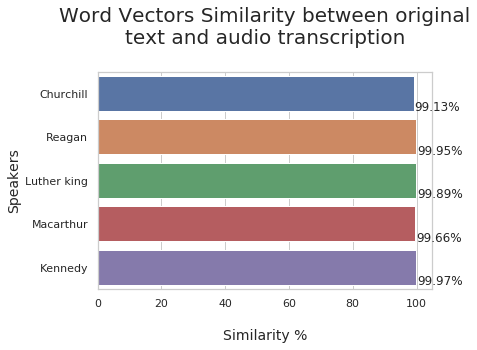

In [31]:
# Plotting the results for similarity between the original transcripts and Amazon Transcribe transcription
sns.set(style="whitegrid")
ax = sns.barplot(y='label_capitalized', x='similarity_perc', 
                 data=df_audio, orient='h')
ax.set_title('Word Vectors Similarity between original\ntext and audio transcription\n', fontsize=20)
ax.set_xlabel('\nSimilarity %', fontsize=14)
ax.set_ylabel('Speakers', fontsize=14)

show_values_on_bars(ax, "h", 0.3)
ax.figure.savefig("word2vec_similarity.png", dpi=400, bbox_inches='tight')

# Getting similarity with Word Movers Distance (WMD)

In [34]:
# Iterate over the speakers comparing the transcription texts using spaCy and wmd
for index, row in df_audio.iterrows():
    nlp = spacy.load('en_core_web_lg')
    nlp.add_pipe(wmd.WMD.SpacySimilarityHook(nlp), last=True)
    original_transcription = nlp(process_text(original_transcriptions.get(index)))
    transcribe_transcription = nlp(process_text(get_text_from_json(bucket_name, row.json_transcription)))
    wmd_similarity = original_transcription.similarity(transcribe_transcription)
    
    df_audio.at[index, 'wmd_similarity'] = wmd_similarity
    print(f'Word Movers Distance Similarity for {index}\'s speech: {wmd_similarity}')   

Word Movers Distance Similiraty for churchill's speech: 2.0861682891845703
Word Movers Distance Similiraty for reagan's speech: 0.4250998795032501
Word Movers Distance Similiraty for luther_king's speech: 0.860197126865387
Word Movers Distance Similiraty for macarthur's speech: 1.4768357276916504
Word Movers Distance Similiraty for kennedy's speech: 0.43608832359313965


In [35]:
df_audio

,youtube_urls,filename,url,transcription_url,json_transcription,w2v_text_similarity,label_capitalized,similarity_perc,wmd_similarity
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...,https://medium-nlp-aws.s3.amazonaws.com/WE+SHA...,https://medium-nlp-aws.s3.amazonaws.com/church...,churchill_speech_06092019.json,0.991292,Churchill,99.129217,2.086168
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...,https://medium-nlp-aws.s3.amazonaws.com/'Berli...,https://medium-nlp-aws.s3.amazonaws.com/reagan...,reagan_speech_06092019.json,0.999452,Reagan,99.945200,0.425100
luther_king,https://www.youtube.com/watch?v=I47Y6VHc3Ms,Martin Luther King _ 'I Have A Dream' Speech-I...,https://medium-nlp-aws.s3.amazonaws.com/Martin...,https://medium-nlp-aws.s3.amazonaws.com/luther...,luther_king_speech_06092019.json,0.998881,Luther king,99.888072,0.860197
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s,"Duty, Honor, Country _ Douglas MacArthur _ May...","https://medium-nlp-aws.s3.amazonaws.com/Duty,+...",https://medium-nlp-aws.s3.amazonaws.com/macart...,macarthur_speech_06092019.json,0.996570,Macarthur,99.656970,1.476836
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,'We choose to go to the moon' Speech by Presid...,https://medium-nlp-aws.s3.amazonaws.com/'We+ch...,https://medium-nlp-aws.s3.amazonaws.com/kenned...,kennedy_speech_06092019.json,0.999676,Kennedy,99.967626,0.436088


In [36]:
def show_values_on_bars_wmd(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = f'{round(p.get_width(),2)}'
                ax.text(_x, _y, value, ha="center")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

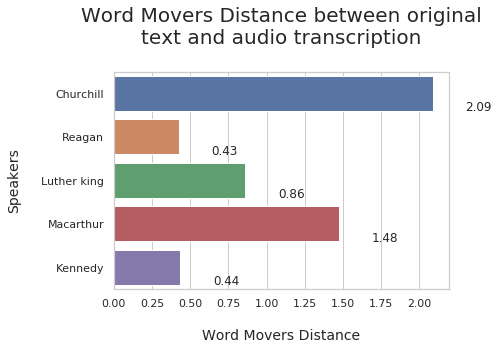

In [37]:
# Plotting the results for WMD
sns.set(style="whitegrid")
ax = sns.barplot(y='label_capitalized', x='wmd_similarity', 
                 data=df_audio, orient='h')
ax.set_title('Word Movers Distance between original\ntext and audio transcription\n', fontsize=20)
ax.set_xlabel('\nWord Movers Distance', fontsize=14)
ax.set_ylabel('Speakers\n', fontsize=14)

show_values_on_bars_wmd(ax, "h", 0.3)
ax.figure.savefig("wmd.png", dpi=400, bbox_inches='tight')

## Create visual representation for entity recognition with displaCy

In [38]:
# Iterate over the speakers comparing the transcription texts using spaCy
for index, row in df_audio.iterrows():
    print(f"Rendering {index}'s texts")    
    nlp = spacy.load('en_core_web_lg')
    original_transcription = nlp(original_transcriptions.get(index))    
    transcribe_transcription = nlp(get_text_from_json(bucket_name, row.json_transcription))
    
    svg_original = spacy.displacy.render(original_transcription, style="ent",jupyter=False)
    svg_transcribe = spacy.displacy.render(transcribe_transcription, style="ent",jupyter=False)
    
    with open(f'{index}_original.html', 'w',  encoding="utf-8") as page:
        page.write(svg_original)
    with open(f'{index}_transcribe.html', 'w',  encoding="utf-8") as page:
        page.write(svg_transcribe)

Rendering churchill's texts
Rendering reagan's texts
Rendering luther_king's texts
Rendering macarthur's texts
Rendering kennedy's texts


# Sentiment analysis using Amazon Comprehend

In [40]:
def start_comprehend_job(text):
    """
    Executes sentiment analysis of a text using Amazon Comprehend.
    The text can be larger than 5000 bytes (one limitation for each job), as 
    the function will split it into multiple processes and return a 
    averaged value for each sentiment.
    
    Parameter
    - text (str): The text to be analyzed
    
    Return
    - final_dict (dict): Dictionary with the percentage of each one of the 4 
    sentiments evaluated on Amazon Comprehend model (positive, negative, 
    neutral, mixed)
    """
    list_parts = []
    text_for_analysis = ''
    for sentence in text.split('.'):
        current_text = text_for_analysis + f'{sentence}.'

        if len(current_text.encode('utf-8')) > 5000:
            list_parts.append([len(text_for_analysis), text_for_analysis])
            text_for_analysis = f'{sentence}.'

        else:
            text_for_analysis += f'{sentence}.'

    list_parts.append([len(text_for_analysis), text_for_analysis])
    dict_comprehend = {}
    for t_parts in list_parts:
       
        comprehend_client = boto3.client(service_name='comprehend', region_name='us-east-1')
        sentimentData = comprehend_client.detect_sentiment(Text=t_parts[1], LanguageCode='en')
        
        dict_comprehend[t_parts[0]] = sentimentData
        dict_comprehend[t_parts[0]]['ratio'] = t_parts[0]/float(len(text))

    final_dict = {'Positive':0, 'Negative':0, 'Neutral':0, 'Mixed':0}
    list_sentiments = ['Positive', 'Negative', 'Neutral', 'Mixed']
    for sentiment in list_sentiments:
        for key, value in dict_comprehend.items():
            final_dict[sentiment] += value.get('SentimentScore').get(sentiment) * value.get('ratio')
    
    return final_dict

In [30]:
# Run the sentiment analysis using start_comprehend_job function
for index, row in df_audio.iterrows():
    transcript_text = get_text_from_json(bucket_name, row.json_transcription)
    comprehend_results = start_comprehend_job(transcript_text)
    for k,v in comprehend_results.items():
        df_audio.at[index, k] = v    

In [33]:
# Arrendodar os valores percentuais dos sentimentos
# Round the sentiment values
df_audio =  df_audio.round(2)
df_audio

,youtube_urls,filename,url,transcription_url,json_transcription,text_similarity,label_capitalized,similarity_perc,Positive,Negative,Neutral,Mixed
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,churchill_radar.png,https://medium-nlp-aws.s3.amazonaws.com/church...,https://medium-nlp-aws.s3.amazonaws.com/church...,churchill_speech_06092019.json,1.0,Churchill,99.55,0.28,0.06,0.52,0.13
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...,https://medium-nlp-aws.s3.amazonaws.com/'Berli...,https://medium-nlp-aws.s3.amazonaws.com/reagan...,reagan_speech_06092019.json,1.0,Reagan,99.92,0.16,0.02,0.81,0.02
luther_king,https://www.youtube.com/watch?v=I47Y6VHc3Ms,Martin Luther King _ 'I Have A Dream' Speech-I...,https://medium-nlp-aws.s3.amazonaws.com/Martin...,https://medium-nlp-aws.s3.amazonaws.com/luther...,luther_king_speech_06092019.json,1.0,Luther king,99.67,0.34,0.01,0.59,0.06
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s,"Duty, Honor, Country _ Douglas MacArthur _ May...","https://medium-nlp-aws.s3.amazonaws.com/Duty,+...",https://medium-nlp-aws.s3.amazonaws.com/macart...,macarthur_speech_06092019.json,1.0,Macarthur,99.64,0.25,0.02,0.64,0.08
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,'We choose to go to the moon' Speech by Presid...,https://medium-nlp-aws.s3.amazonaws.com/'We+ch...,https://medium-nlp-aws.s3.amazonaws.com/kenned...,kennedy_speech_06092019.json,1.0,Kennedy,99.93,0.36,0.01,0.58,0.05


## Visualizing the sentiment analysis results


In [68]:
df_sentiment = df_audio[['label_capitalized','Positive', 'Negative', 'Neutral', 'Mixed']]
#df_sentiment['author'] = df_sentiment.label_capitalized
df_sentiment

,label_capitalized,Positive,Negative,Neutral,Mixed
churchill,Churchill,0.28,0.06,0.52,0.13
reagan,Reagan,0.16,0.02,0.81,0.02
luther_king,Luther king,0.34,0.01,0.59,0.06
macarthur,Macarthur,0.25,0.02,0.64,0.08
kennedy,Kennedy,0.36,0.01,0.58,0.05


In [75]:
# Fazer o melt do Dataframe com os resultados para facilitar a visualização
# Melt dataframe for easier viewing
df_melt = pd.melt(df_sentiment, id_vars="label_capitalized", var_name="sentiment", value_name="sentiment_rate")
df_melt

,label_capitalized,sentiment,sentiment_rate
0,Churchill,Positive,0.28
1,Reagan,Positive,0.16
2,Luther king,Positive,0.34
3,Macarthur,Positive,0.25
4,Kennedy,Positive,0.36
5,Churchill,Negative,0.06
6,Reagan,Negative,0.02
7,Luther king,Negative,0.01
8,Macarthur,Negative,0.02
9,Kennedy,Negative,0.01


In [80]:
df_melt['sentiment_percentage'] = df_melt.sentiment_rate * 100
df_melt

,label_capitalized,sentiment,sentiment_rate,sentiment_percentage
0,Churchill,Positive,0.28,28.0
1,Reagan,Positive,0.16,16.0
2,Luther king,Positive,0.34,34.0
3,Macarthur,Positive,0.25,25.0
4,Kennedy,Positive,0.36,36.0
5,Churchill,Negative,0.06,6.0
6,Reagan,Negative,0.02,2.0
7,Luther king,Negative,0.01,1.0
8,Macarthur,Negative,0.02,2.0
9,Kennedy,Negative,0.01,1.0


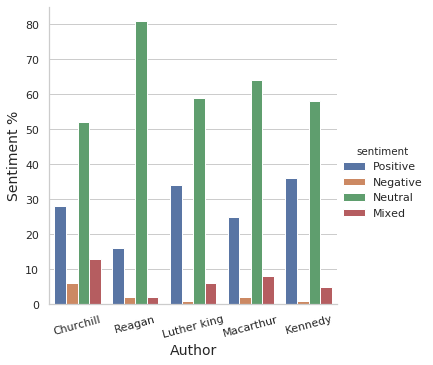

In [82]:
# Barplot for the results
#sns.set(style="whitegrid")
#ax = sns.barplot(y='label_capitalized', x='similarity_perc', 
#                 data=df_audio, orient='h')

sns_plot = sns.factorplot(x='label_capitalized', y='sentiment_percentage', hue='sentiment', data=df_melt, kind='bar')
sns_plot.set_xticklabels(rotation=15)
sns_plot.set_xlabels('Author', fontsize=14)
sns_plot.set_ylabels('Sentiment %', fontsize=14)
sns_plot.set_titles('Sentiment Analysis')
sns_plot.savefig("barplot.png", dpi=600, orientation ='landscape', bbox_inches='tight')
ax.figure.savefig("similarity.png", dpi=400)

In [41]:
df_t = df_sentiment.drop('label_capitalized', axis=1).T
df_t = df_t.reindex(index = ['Positive', 'Neutral', 'Negative', 'Mixed'])
df_t

,churchill,reagan,luther_king,macarthur,kennedy
Positive,0.28,0.16,0.34,0.25,0.36
Neutral,0.52,0.81,0.59,0.64,0.58
Negative,0.06,0.02,0.01,0.02,0.01
Mixed,0.13,0.02,0.06,0.08,0.05


/home/gabriel/miniconda3/envs/nlp_aws/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


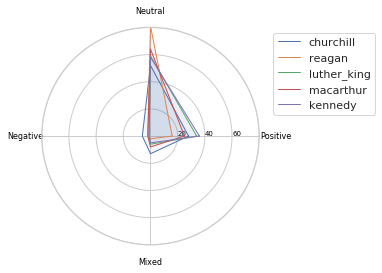

In [64]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
# number of variable
categories=['Positive', 'Neutral', 'Negative', 'Mixed']
colors = ['']
N = len(categories)
legend = []

for n in range(len(df_t.columns)):
    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values= df_t[df_t.columns[n]].tolist()
    values += values[:1]
    legend.append(df_t.columns[n])
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6, 0.8], ["20","40","60", ""], color="black", size=7)
    plt.ylim(0,0.80)

    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    
    # Add legend
    #ax.legend(legend, loc='upper left')
    plt.legend(legend, bbox_to_anchor=(1.04,1), loc="upper left")

    '''box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
    '''
    # Fill area
    ax.fill(angles, values, 'b', alpha=0.05)

plt.savefig(f'all_speakers_radar.png', dpi=1200, 
            bbox_inches='tight',
                orientation='landscape')
                #figsize=(16, 9))
plt.show()
    #plt.clf()


References
* Audio recognition tutorial with Python https://realpython.com/python-speech-recognition/
* Tutorial on how to download Youtube using Python https://itsfoss.com/download-youtube-linux/
* Youtube-DL GitHub Project https://github.com/ytdl-org/youtube-dl/blob/master/README.md#readme
* Article on the Greatest speeches in history https://www.artofmanliness.com/articles/the-35-greatest-speeches-in-history/
* Tutorial for configuring boto3 https://boto3.amazonaws.com/v1/documentation/api/latest/guide/quickstart.html#using-boto-3
* Tutorial on Json with Python https://realpython.com/python-json/
* Datacamp Course "Natural Language Processing Fundamentals in Python" https://www.datacamp.com/courses/natural-language-processing-fundamentals-in-python
* Datacamp Course "Adavanced NLP with spaCy" https://www.datacamp.com/courses/advanced-nlp-with-spacy